In [1]:
import os
from os import walk

import pandas as pd
import numpy as np
import sys
import re

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from collections import Counter

from parse_data import *

%matplotlib inline

pd.set_option('display.max_rows', 9000)
pd.set_option('display.max_columns', 1500)
pd.set_option('max_colwidth', 400)

In [2]:
#Set to False if no subsampling, else set to the desired number for subsample results:
#subsampling = "1"
subsampling = 100

output_data_path = 'result_data/'

reference_data_path  = '../reference_data/'

#Outcomment all but the resolution desired:
if subsampling == False:
    resultpath = '../output_full_dataset/'
else:
    resultpath = f'../downsampling_results/output_{subsampling}X/1000_genomes_results/'



## Create one conversion function (1-field, 2-field, P group, NetMHCseq group)

In [3]:
def flatten(a):
    return [item for sublist in a for item in sublist if item != []]

In [4]:
#Make function for conversion, to be used in this run of the notebook:
p_group_dict = make_p_group_dict()
e_group_dict = make_e_group_dict()

def convert_allele(allele, resolution = 'two_field'):

    """
    input:
    allele (str): An allele in the format (A|B|C|DRB1|DQB1)\*\d{2}:\d{2,3}:?\d{0,3}G?:?\d{0,3} to be converted.
    resolution:   the resolution, with which the allele is converted to

    """
    if resolution == "one_field":
        converted_allele = convert_to_one_field(allele)
    
    elif resolution == "two_field":
        converted_allele = convert_to_two_field(allele)
        
    elif resolution == "p_group":
        converted_allele = convert_to_p_group(allele, p_group_dict=p_group_dict)
    
    elif resolution == "e_group":
        converted_allele = convert_to_e_group(allele, e_group_dict=e_group_dict, p_group_dict=p_group_dict)
            
    else:
        print("A conversion mistake happend. Please specify a correct conversion type.")
        converted_allele = None
        
    return converted_allele      

# Load Typing Results by HLA Typing tools:

## Kourami
Save both single and ambiguous results

In [5]:
kourami_result_filepath = resultpath + 'kourami/'

kourami_log_filepath = resultpath + 'kourami_results_from_logfiles/'

kourami_files = list()
kourami_logfiles = list()

#Initalize result dict for single guess and for multiple typing
kourami_results = dict()
kourami_results_ambiguous = dict()


for (dirpath, dirnames, filenames) in walk(kourami_result_filepath):
    kourami_files.extend(filenames)
    
for (dirpath, dirnames, filenames) in walk(kourami_log_filepath):
    kourami_logfiles.extend(filenames)
    

for filename in kourami_files:
    #Don't include the performance logs
    if filename.endswith('.txt'):
        
        #If file is not empty:
        if os.stat(kourami_result_filepath + filename).st_size != 0:
            temp_result_dict = dict()
            temp_result_dict_ambiguous = dict()
    
            with open(kourami_result_filepath + filename, 'r') as infile:

                for line in infile:
                    #Find the first match / allele prediction
                    allele_searcher = re.search(r"(A|B|C|DRB1|DQB1)\*\d{2}:\d{2,3}:?\d{0,3}G?:?\d{0,3}", line)
                    
                    #Find all allele predictions (ambiguous). ?: is required for non-capturing groups
                    allele_searcher_ambiguous = re.findall(r"(?:A|B|C|DRB1|DQB1)\*\d{2}:\d{2,3}:?\d{0,3}G?:?\d{0,3}", line)
                    
                    if allele_searcher is not None:                        
                        found_allele = allele_searcher.group(0)
                        
                        gene = re.search(r"(A|B|C|DRB1|DQB1)", found_allele).group(0)
                        
                        #Convert alleles to right resolution:
                        pred_converted = convert_allele(found_allele)
                        #pred_converted = found_allele
                        if pred_converted != convert_to_two_field(found_allele):
                            print(filename)

                        allele_searcher_ambiguous_converted = [convert_allele(i) for i in allele_searcher_ambiguous]

                        #Add to list of predictions for this sample
                        if gene not in temp_result_dict.keys():
                            temp_result_dict[gene] = [[pred_converted]]
                            temp_result_dict_ambiguous[gene] = [allele_searcher_ambiguous_converted]
                        else:
                            temp_result_dict[gene] += [[pred_converted]]
                            temp_result_dict_ambiguous[gene] += [allele_searcher_ambiguous_converted]

            #Add sample prediction to dict
            kourami_results[filename[:-4]] = temp_result_dict
            kourami_results_ambiguous[filename[:-4]] = temp_result_dict_ambiguous
            
            
        #If file is empty, add an empty dict.
        else:
            kourami_results[filename[:-4]] = dict()
            kourami_results_ambiguous[filename[:-4]] = dict()
            #print("Unable to load results for sample" + filename[:-4] + ". No prediction added")                           
                
#kourami_results

## HLA-LA

In [6]:
hla_la_result_filepath = resultpath + 'hla-la/'

hla_la_files = []
for (dirpath, dirnames, filenames) in walk(hla_la_result_filepath):
    hla_la_files.extend(filenames)
    
#print(hla_la_files)


hla_la_results = dict()

for filename in hla_la_files:
    if filename.endswith('.txt'):
        temp_results_object = pd.read_csv(hla_la_result_filepath + filename, sep = "\t")['Allele']
        temp_results = [i for i in temp_results_object if i.startswith(('A', 'B', 'C', 'DRB1', 'DQB1'))]
        
        
        #Make dict of dicts for results:
        temp_result_dict = dict()
        
        for pred in temp_results:
            gene = re.search(r"(A|B|C|DRB1|DQB1)", pred).group(0)
            
            pred_converted = convert_allele(pred)
            #pred_converted = pred          
            
            #Add to list of predictions for this sample
            if gene not in temp_result_dict.keys():
                temp_result_dict[gene] = [[pred_converted]]
            else:
                temp_result_dict[gene] += [[pred_converted]]

        
        hla_la_results[filename[:-4]] = temp_result_dict


#hla_la_results

## Optitype

In [7]:
optitype_result_filepath = resultpath + 'optitype/'

optitype_files = []
for (dirpath, dirnames, filenames) in walk(optitype_result_filepath):
    optitype_files.extend(filenames)
    
#print(optitype_files)


optitype_results = dict()

for filename in optitype_files:
    
    #Check for right file, and that the file is not empty
    if (filename.endswith('.txt')) and (os.stat(optitype_result_filepath + filename).st_size != 0):
        temp_results_raw = list(pd.read_csv(optitype_result_filepath + filename, sep = "\t").iloc[0])[1:7]

        temp_results = [i for i in temp_results_raw if isinstance(i,str)]
  
        #Make dict of dicts for results:
        temp_result_dict = dict()
        
        for pred in temp_results:
            gene = re.search(r"(A|B|C|DRB1|DQB1)", pred).group(0)
            
            pred_converted = convert_allele(pred)
            #pred_converted = pred
            
            #Add to list of predictions for this sample
            if gene not in temp_result_dict.keys():
                temp_result_dict[gene] = [[pred_converted]]
            else:
                temp_result_dict[gene] += [[pred_converted]]
      
        optitype_results[filename[:-4]] = temp_result_dict
 
    #Add empty entry for empty file
    elif (filename.endswith('.txt')) and (os.stat(optitype_result_filepath + filename).st_size == 0):
        optitype_results[filename[:-4]] = dict()
        
#optitype_results

## Hisatgenotype

In [8]:
hisatgenotype_result_filepath = resultpath + 'hisatgenotype/'

hisatgenotype_files = []
for (dirpath, dirnames, filenames) in walk(hisatgenotype_result_filepath):
    hisatgenotype_files.extend(filenames)
    
#print(hisatgenotype_files)

#Save two predictions. One, with one guess per allele and one with the full prediction
hisatgenotype_results = dict()

for filename in hisatgenotype_files:
    if filename.endswith('.txt'):
    
        hisatgenotype_resultlist = list()
        
        hisatgenotype_resultlist_ambiguous = list()
      
        with open(hisatgenotype_result_filepath + filename) as infile:
            for line in infile:
                result = re.match(r'^\t+(1|2)\sranked (A|B|C|DRB1|DQB1)',line)
            
                if result is not None:
                    hisatgenotype_resultlist.append(line.split()[2])              
                     
            #Duplicate prediction for an allele in case of homologous case, so that each gene has two predictions.
            #In a homologous case, both result dicts only have one prediction and both needs an update.
            for allele in ['A', 'B', 'C', 'DRB1', 'DQB1']:
                allele_list = [pred for pred in hisatgenotype_resultlist if pred.startswith(allele)]

                if len(allele_list) == 1:
                    hisatgenotype_resultlist.append(allele_list[0])
                    hisatgenotype_resultlist.sort()

            temp_results = hisatgenotype_resultlist
            
        #Make dict of dicts for results:
        temp_result_dict = dict()
        
        for pred in temp_results:
            gene = re.search(r"(A|B|C|DRB1|DQB1)", pred).group(0)
            
            pred_converted = convert_allele(pred)
            #pred_converted = pred
            
            #Add to list of predictions for this sample
            if gene not in temp_result_dict.keys():
                temp_result_dict[gene] = [[pred_converted]]
            else:
                temp_result_dict[gene] += [[pred_converted]]


        hisatgenotype_results[filename[:-4]] = temp_result_dict
                
#hisatgenotype_results           
        

## STC-seq

In [9]:
stc_seq_result_filepath = resultpath + 'stc-seq/'

stc_seq_files = []
for (dirpath, dirnames, filenames) in walk(stc_seq_result_filepath):
    stc_seq_files.extend(filenames)
    
#print(stc_seq_files)

stc_seq_results = dict()

for filename in stc_seq_files:
    if filename.endswith('.txt'):
        
        #Get raw results as lists
        stc_df = pd.read_csv(stc_seq_result_filepath + filename, sep = "\t").reset_index()
        stc_df.columns = stc_df.iloc[0]
        stc_list = list(stc_df[stc_df['Locus'].isin(['A', 'B', 'C','DRB1', 'DQB1'])]['Genotype'])
        stc_seq_alt_list = list(stc_df[stc_df['Locus'].isin(['A', 'B', 'C','DRB1', 'DQB1'])]['Alternative_genotype'].dropna())

        #Format results for single prediction
        temp_results =  flatten([i.split(',') for i in stc_list])
        
        
        #Make dict of dicts for results:
        temp_result_dict = dict()
        
        for pred in temp_results:
            gene = re.search(r"(A|B|C|DRB1|DQB1)", pred).group(0)

            pred_converted = convert_allele(pred)
            #pred_converted = pred
            
            #Add to list of predictions for this sample
            if gene not in temp_result_dict.keys():
                temp_result_dict[gene] = [[pred_converted]]
            else:
                temp_result_dict[gene] += [[pred_converted]]

                
        #Add predictions to dicts
        stc_seq_results[filename[:-4]] = temp_result_dict

#stc_seq_results

## Depth analysis

In [10]:
#load data
depth_filepath = resultpath + 'depth/'

depth_files = []
for (dirpath, dirnames, filenames) in walk(depth_filepath):

    depth_files.extend(filenames)

depth_results = dict()

for filename in depth_files:
    
    if filename.endswith('.depth.mosdepth.summary.txt'):
        temp_results = pd.read_csv(depth_filepath + filename, sep='\t')
        
        temp_results.set_index('chrom', inplace=True)
        
        mean_region_depth = temp_results.loc['total_region', 'mean']
        depth_results[filename[0:7]] = mean_region_depth
    
#depth_results

# Load Gold standard data

In [11]:
#Load data
MG_exome_merged_df = pd.read_pickle(output_data_path + "MG_exome_merged_df.pkl")

gs_two_field_df = pd.read_pickle(output_data_path + "gs_two_field_df.pkl")

gold_standard_id_list = list(MG_exome_merged_df.index)

#Only pick the 221 chosen samples, if this is for downsampling:
if subsampling != False:
    gold_standard_id_list = list(kourami_results.keys())
    
MG_exome_merged_df = MG_exome_merged_df.loc[gold_standard_id_list]

gs_two_field_df = gs_two_field_df.loc[gold_standard_id_list]

# Chose which dataframe should be the gold standard (pick between resolutions)
gold_standard_df = gs_two_field_df

## Allele diversity in the tools and the 1000G dataset

In [12]:
tool_gene_count = dict()

tool_gene_count['1000G reference'] = dict()
for gene in gs_two_field_df.columns:
    tool_gene_count['1000G reference'][gene] = list()
    for patient in gs_two_field_df[gene].values:
        for alleles in patient:
            for allele in alleles:
                tool_gene_count['1000G reference'][gene].append(convert_allele(allele=allele, resolution='p_group'))

tool_gene_count['Kourami'] = dict()
check = dict()
for patient, typing in kourami_results.items():
    for gene, locus_typing in typing.items():
        if gene not in check:
            tool_gene_count['Kourami'][gene] = list()
            check[gene] = ''   

        for alleles in locus_typing:
            for allele in alleles:
                tool_gene_count['Kourami'][gene].append(convert_allele(allele=allele, resolution='p_group'))

tool_gene_count['HLA-LA'] = dict()
check = dict()
for patient, typing in hla_la_results.items():
    for gene, locus_typing in typing.items():
        if gene not in check:
            tool_gene_count['HLA-LA'][gene] = list()
            check[gene] = ''        

        for alleles in locus_typing:
            for allele in alleles:
                tool_gene_count['HLA-LA'][gene].append(convert_allele(allele=allele, resolution='p_group'))

tool_gene_count['HISAT-genotype'] = dict()
check = dict()
for patient, typing in hisatgenotype_results.items():
    for gene, locus_typing in typing.items():
        if gene not in check:
            tool_gene_count['HISAT-genotype'][gene] = list()
            check[gene] = ''        

        for alleles in locus_typing:
            for allele in alleles:
                tool_gene_count['HISAT-genotype'][gene].append(convert_allele(allele=allele, resolution='p_group'))


tool_gene_count['STC-Seq'] = dict()
check = dict()
for patient, typing in stc_seq_results.items():
    for gene, locus_typing in typing.items():
        if gene not in check:
            tool_gene_count['STC-Seq'][gene] = list()
            check[gene] = ''        

        for alleles in locus_typing:
            for allele in alleles:
                tool_gene_count['STC-Seq'][gene].append(convert_allele(allele=allele, resolution='p_group'))

tool_gene_count['Optitype'] = dict()
check = dict()
for patient, typing in optitype_results.items():
    for gene, locus_typing in typing.items():
        if gene not in check:
            tool_gene_count['Optitype'][gene] = list()
            check[gene] = ''        

        for alleles in locus_typing:
            for allele in alleles:
                tool_gene_count['Optitype'][gene].append(convert_allele(allele=allele, resolution='p_group'))

tool_gene_count['Optitype']['DRB1'] = []
tool_gene_count['Optitype']['DQB1'] = []

# for method, typing in tool_gene_count.items():
#     for loci, alleles in typing.items():
#         print(f'{method}\t{loci}\t{len(alleles)}')

# loci_counter_dict = dict()
# for loci in ['A', 'B', 'C', 'DRB1', 'DQB1']:
#     loci_counter_dict[loci] = {method : len(set(call_list[loci])) for method, call_list in tool_gene_count.items()}

method_counter_dict = dict()
for tool in tool_gene_count:
    method_counter_dict[tool] = {loci : len(set(call_list)) for loci, call_list in tool_gene_count[tool].items()}

In [34]:
sns.color_palette('colorblind').as_hex()

['#0173b2',
 '#de8f05',
 '#029e73',
 '#d55e00',
 '#cc78bc',
 '#ca9161',
 '#fbafe4',
 '#949494',
 '#ece133',
 '#56b4e9']

In [33]:
print(sns.color_palette('colorblind').as_hex())

['#0173b2', '#de8f05', '#029e73', '#d55e00', '#cc78bc', '#ca9161', '#fbafe4', '#949494', '#ece133', '#56b4e9']


In [25]:
import seaborn as sns 
grey_list_hex = ['808080']
grey_rgb_tuple = [tuple(int(h[i:i+2], 16)/256 for i in (0, 2, 4)) for h in grey_list_hex]

palette_list = grey_rgb_tuple + list(sns.color_palette("colorblind"))

def make_plot_from_allele_list(title):

    fig, ax = plt.subplots(1, 1, figsize=(12,8))

    df = pd.DataFrame(method_counter_dict)
    df.plot(kind='bar', color = palette_list, ax=ax)  
   
    ax.legend()

    def autolabel(rects, y_height):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{:.1f}'.format(height, ),
                        xy=(rect.get_x() + rect.get_width() / 2, y_height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', 
                        color="black", size = 16, weight =400)
   
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)       
    
    ax.tick_params(axis="y", labelsize=16)
    ax.tick_params(axis='x', labelsize=16, rotation=0)

    # # Or if you want different settings for the grids:
    ax.grid(axis = 'y')
    ax.set_ylim(0,df.max().max()+25)

    ax.legend(loc='best', prop={'size': 14})

    ax.set_title(title, size = 20)

    plt.tight_layout()
    
    return plt, df

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


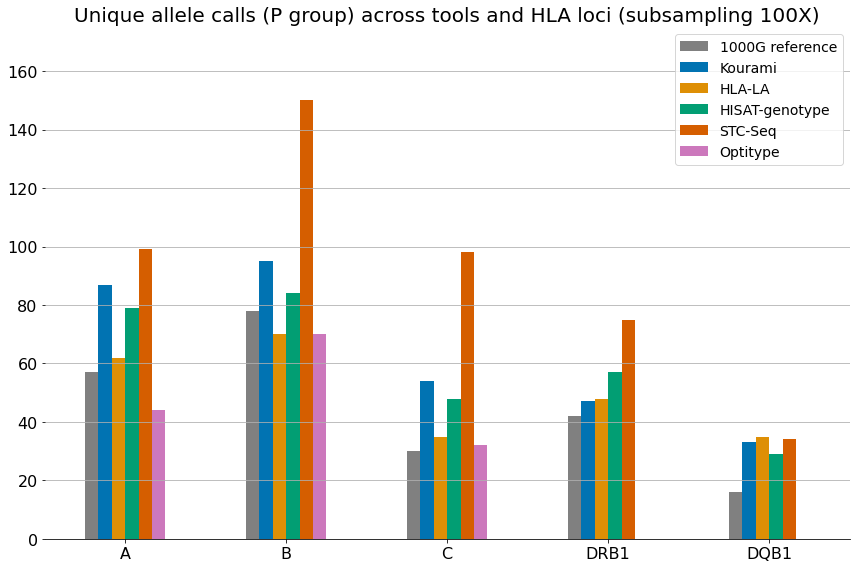

In [27]:
if subsampling == False:
    plot, unique_alleles_df = make_plot_from_allele_list('Unique allele calls (P group) across tools and HLA loci')
    plot.savefig('plots/unique_allele_calls.eps')
    unique_alleles_df.to_csv('result_data/unique_allele_calls_full_dataset.csv')
else:
    plot, unique_alleles_df = make_plot_from_allele_list(f'Unique allele calls (P group) across tools and HLA loci (subsampling {subsampling}X)')
    plot.savefig(f'plots/unique_allele_calls_subsampling_{subsampling}X.eps')
    unique_alleles_df.to_csv(f'result_data/unique_allele_calls_{subsampling}X.csv')

# Typing accuracy and Call rate of the tools

In [16]:
gold_standard_df = gs_two_field_df
gold_standard_df.head()

,A,B,C,DRB1,DQB1
id,,,,,
HG00732,"[[A*11:21, A*11:01], [A*30:02]]","[[B*18:17, B*18:01], [B*35:94, B*35:42, B*35:40, B*35:01, B*35:57]]","[[C*04:41, C*04:30, C*04:09, C*04:01, C*04:28], [C*05:01, C*05:03]]","[[DRB1*03:01], [DRB1*14:54, DRB1*14:01]]","[[DQB1*02:01, DQB1*02:04, DQB1*02:02], [DQB1*05:03]]"
NA19471,"[[A*23:18, A*23:07, A*23:17, A*23:01, A*23:20], [A*29:02]]","[[B*53:01], [B*73:01]]","[[C*06:02], [C*15:05]]","[[DRB1*03:01], [DRB1*11:01]]","[[DQB1*02:01, DQB1*02:04, DQB1*02:02], [DQB1*06:02]]"
NA12282,"[[A*01:01], [A*02:01]]","[[B*08:01], [B*37:01]]","[[C*03:04], [C*06:02]]","[[DRB1*03:01], [DRB1*10:01]]","[[DQB1*02:01], [DQB1*05:01]]"
HG00734,"[[A*03:01, A*03:20, A*03:21, A*03:26, A*03:45, A*03:37], [A*33:01]]","[[B*07:44, B*07:49, B*07:61, B*07:02, B*07:59, B*07:58], [B*14:02]]","[[C*07:74, C*07:50, C*07:02, C*07:66], [C*08:02]]","[[DRB1*11:01], [DRB1*04:11]]","[[DQB1*03:02], [DQB1*06:02]]"
NA19210,"[[A*03:01, A*03:20, A*03:21, A*03:26, A*03:45, A*03:37], [A*33:01]]","[[B*15:10], [B*58:01, B*58:11]]","[[C*03:02], [C*08:04]]","[[DRB1*03:01], [DRB1*13:01]]","[[DQB1*03:22, DQB1*03:09, DQB1*03:01, DQB1*03:19, DQB1*03:21, DQB1*03:24], [DQB1*06:03]]"


In [17]:
def validate_call(correct_alleles, predicted_alleles, resolution):
    #Start by converting the alleles to the correct resolution
    correct_call_1 = {convert_allele(allele, resolution=resolution) for allele in correct_alleles[0]}
    correct_call_2 = {convert_allele(allele, resolution=resolution) for allele in correct_alleles[1]}

    pred_1 = {convert_allele(predicted_alleles[0][0], resolution=resolution)}
    pred_2 = {convert_allele(predicted_alleles[1][0], resolution=resolution)}

    try:
        correct_0_pred_0 = list(correct_call_1.intersection(pred_1))
        correct_1_pred_1  = list(correct_call_2.intersection(pred_2))

        option_1 = [correct_0_pred_0, correct_1_pred_1]

        correct_0_pred_1  = list(correct_call_1.intersection(pred_2))
        correct_1_pred_0  = list(correct_call_2.intersection(pred_1))

        option_2 = [correct_0_pred_1, correct_1_pred_0]

        hits_1 = len([i for i in option_1 if i != []])
        hits_2 = len([i for i in option_2 if i != []])

        num_correct_hits = max(hits_1,hits_2)
        
        
    except KeyError as error:
        num_correct_hits = 0
    
    return num_correct_hits

#Get the number of predictions from a tool for a specific allele for a specific subject (2 or 0)
def get_count(tool_prediction, locus, subject):
    try:
        pred = tool_prediction[subject][locus]
        return len(pred)
    except KeyError as error:
        return 0

In [18]:
typing_results_dict = {
    'Kourami' : kourami_results,
    'HLA-LA' : hla_la_results,
    'Optitype' : optitype_results,
    'Hisatgenotype' : hisatgenotype_results,
    'STC-seq' : stc_seq_results,
}

def validate_typing(typing_results_dict, gold_standard_df, subject_id_list, resolution):
    results_dict = dict()
    #Loop over subjects, loci and tools
    for tool in typing_results_dict:
        results_dict[tool] = dict()
        
        for locus in gold_standard_df.columns:
            results_dict[tool][locus] = dict()
            results_dict[tool][locus]['count'] = 0
            results_dict[tool][locus]['score'] = 0

            #Find counts of calls and correct calls
            for subject in subject_id_list:

                #If typing exists:
                if subject in typing_results_dict[tool]:
                    if locus in typing_results_dict[tool][subject]:
                        #Count number of total calls:
                        results_dict[tool][locus]['count'] += get_count(typing_results_dict[tool], locus, subject)
                    
                        #check whether it is valid.
                        correct_alleles_list = gold_standard_df.loc[subject, locus]
                        predicted_alleles = typing_results_dict[tool][subject][locus]
                        results_dict[tool][locus]['score'] += validate_call(correct_alleles_list, predicted_alleles, resolution)
            

        #Add entries for all class I, class II and all alleles
        results_dict[tool]['HLA-I'] = dict()
        results_dict[tool]['HLA-II'] = dict()
        results_dict[tool]['Total'] = dict() 

        results_dict[tool]['HLA-I']['count'] = sum([results_dict[tool][locus]['count'] for locus in ['A', 'B', 'C']]) 
        results_dict[tool]['HLA-II']['count'] = sum([results_dict[tool][locus]['count'] for locus in ['DRB1', 'DQB1']]) 
        results_dict[tool]['Total']['count'] = sum([results_dict[tool][locus]['count'] for locus in ['HLA-I', 'HLA-II']]) 

        results_dict[tool]['HLA-I']['score'] = sum([results_dict[tool][locus]['score'] for locus in ['A', 'B', 'C']]) 
        results_dict[tool]['HLA-II']['score'] = sum([results_dict[tool][locus]['score'] for locus in ['DRB1', 'DQB1']]) 
        results_dict[tool]['Total']['score'] = sum([results_dict[tool][locus]['score'] for locus in ['HLA-I', 'HLA-II']]) 


        #Find total counts and calculate call rate and typing accuracy
        for locus in results_dict[tool]:
            if locus in ['A', 'B', 'C', 'DRB1', 'DQB1']:
                multiplier = 1
            elif locus == 'HLA-I':
                multiplier = 3
            elif locus == 'HLA-II':
                multiplier = 2
            elif locus == 'Total':
                multiplier = 5

            total_correct_calls = multiplier * len(gold_standard_df[gold_standard_df.index.isin(subject_id_list)]) * 2
            results_dict[tool][locus]['call_rate'] = results_dict[tool][locus]['count'] * 100  / total_correct_calls
            results_dict[tool][locus]['typing_accuracy'] = results_dict[tool][locus]['score'] * 100 / total_correct_calls


    return results_dict

In [19]:
#Loop over typing resolutions 
rename_resolutions = {
    'one_field' : '1-field',
    'e_group' : 'pseudosequence',
    'p_group' : 'P group',
    'two_field' : '2-field',
}


four_resolutions_results = dict()
for resolution in ['one_field', 'e_group', 'p_group', 'two_field']:
    four_resolutions_results[rename_resolutions[resolution]] = validate_typing(typing_results_dict=typing_results_dict, gold_standard_df=gs_two_field_df, subject_id_list=gold_standard_id_list, resolution=resolution)

In [20]:
four_resolutions_results

{'1-field': {'Kourami': {'A': {'count': 456,
    'score': 452,
    'call_rate': 99.1304347826087,
    'typing_accuracy': 98.26086956521739},
   'B': {'count': 442,
    'score': 430,
    'call_rate': 96.08695652173913,
    'typing_accuracy': 93.47826086956522},
   'C': {'count': 452,
    'score': 448,
    'call_rate': 98.26086956521739,
    'typing_accuracy': 97.3913043478261},
   'DRB1': {'count': 460,
    'score': 453,
    'call_rate': 100.0,
    'typing_accuracy': 98.47826086956522},
   'DQB1': {'count': 360,
    'score': 335,
    'call_rate': 78.26086956521739,
    'typing_accuracy': 72.82608695652173},
   'HLA-I': {'count': 1350,
    'score': 1330,
    'call_rate': 97.82608695652173,
    'typing_accuracy': 96.3768115942029},
   'HLA-II': {'count': 820,
    'score': 788,
    'call_rate': 89.1304347826087,
    'typing_accuracy': 85.65217391304348},
   'Total': {'count': 2170,
    'score': 2118,
    'call_rate': 94.34782608695652,
    'typing_accuracy': 92.08695652173913}},
  'HLA-LA'

# Save results

In [21]:
#Overall result dataframe:

import json

if subsampling == False:
    filename = f'{output_data_path}results_full_dataset.json'
else:
    filename = f'{output_data_path}results_{subsampling}.json'

with open(filename, 'w', encoding='utf-8') as f:
    json.dump(four_resolutions_results, f, ensure_ascii=False, indent=4)